# LSTM Model for Next Word Prediction

Reference: <br>
https://thecleverprogrammer.com/2020/07/20/next-word-prediction-model/ <br>
https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e

In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Embedding

from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

from nltk.tokenize import sent_tokenize


## import and preprocess the training text file

### read in the .txt file and divide into seperate words

In [2]:
# read the txt dataset
path = 'belling_the_cat.txt'
#path = 'sherlock.txt'
#path = 'metamorphosis_clean.txt'
text = open(path).read().lower()
print('length of the corpus is:', len(text))

length of the corpus is: 980


In [3]:
# split the .txt into seprate words
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)
#words

### feature engineering
Assign a unique integer to each word or symbol because LSTM can only understand real numbers.

In [4]:
unique_words = np.unique(words) # 所有出现过的words（unique删除了出现多次的）
unique_word_index = dict((c, i) for i, c in enumerate(unique_words)) # 把单词对应上数字

In [5]:
WORD_LENGTH = 3 #用前面3个单词预测下一个单词
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
#print(prev_words[1])
#print(next_words[1])


In [6]:
print('number of unique words are:', len(unique_words))

number of unique words are: 109


Now we create our training data and target data by splitting the sequences into the inputs and output labels. 

Here we use the last 5 words to predict the next word. Thus the list of the first 5 words are inputs, and the list of the following word are labels.

Create two numpy arrays:

X for storing the features：X的第i行，第j列，对应到（第i个prev_word list的5个单词当中的第j个，的这个单词对应的index）是1，其余是0

Y for storing its corresponding label：Y的第i行，对应到（next_word list的第i个单词对应的index）是1，其余是0

即X是training data，包含所有前5个word的list；Y是对应的正确答案，包含所有对应的下一个单词

Iterate X and Y if the word is available so that the corresponding position becomes 1.



In [7]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool) #one hot vector
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

X.shape
Y.shape
print(X[0][0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]


## model 1

```
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
```

***INPUT***

You always have to give a three-dimensional array as an input to your LSTM network. 

The first dimension represents the **batch size**, the second dimension represents the **time-steps** and the third dimension represents the **number of units in one input sequence**. For example, the input shape looks like (*batch_size, time_steps, units*). 

***OUTPUT***

Argument **units** represent the number of output units in the LSTM which is 3 here. So output shape is (None, 3) as displayed in ```model.summary()```. The first dimension of output is None because we do not know the batch size in advance. So the actual output shape will be (batch_size, 3) here.




In [8]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words)))) #
model.add(Dense(len(unique_words)))#全链接层？
model.add(Activation('softmax'))#线性=>非线性

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               121856    
_________________________________________________________________
dense (Dense)                (None, 109)               14061     
_________________________________________________________________
activation (Activation)      (None, 109)               0         
Total params: 135,917
Trainable params: 135,917
Non-trainable params: 0
_________________________________________________________________


## train the model

`epoches`
indicates the number of passes of the entire training dataset the machine learning algorithm has completed. Datasets are usually grouped into batches (especially when the amount of data is very large). 

`shuffle`





In [10]:
optimizer = RMSprop(lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.2, batch_size=128, epochs=20).history

/Users/hanyiwang/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
2/2 [==============================] - 3s 488ms/step - loss: 4.8094 - accuracy: 0.0141 - val_loss: 17.8707 - val_accuracy: 0.0278
Epoch 2/20
2/2 [==============================] - 0s 22ms/step - loss: 18.5729 - accuracy: 0.0141 - val_loss: 11.1443 - val_accuracy: 0.0278
Epoch 3/20
2/2 [==============================] - 0s 22ms/step - loss: 9.9165 - accuracy: 0.0352 - val_loss: 13.3592 - val_accuracy: 0.0000e+00
Epoch 4/20
2/2 [==============================] - 0s 22ms/step - loss: 11.7950 - accuracy: 0.0141 - val_loss: 6.7127 - val_accuracy: 0.0278
Epoch 5/20
2/2 [==============================] - 0s 22ms/step - loss: 4.9064 - accuracy: 0.0423 - val_loss: 6.0168 - val_accuracy: 0.0278
Epoch 6/20
2/2 [==============================] - 0s 25ms/step - loss: 3.6212 - accuracy: 0.1479 - val_loss: 6.3972 - val_accuracy: 0.0278
Epoch 7/20
2/2 [==============================] - 0s 22ms/step - loss: 2.7041 - accuracy: 0.3310 - val_loss: 6.9732 - val_accuracy: 0.0278
Epoch 8/20
2/2 [=

Store the model for future use

In [11]:
model.save('m1_metamorphosis.h5')
pickle.dump(history, open("history.p", "wb"))

#model = load_model('keras_next_word_model.h5')
#history = pickle.load(open("history.p", "rb"))

## evaluate the model

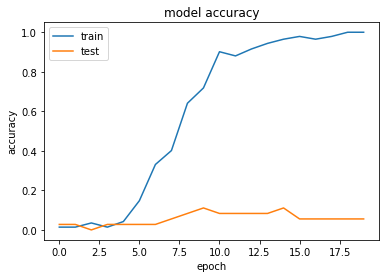

In [12]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

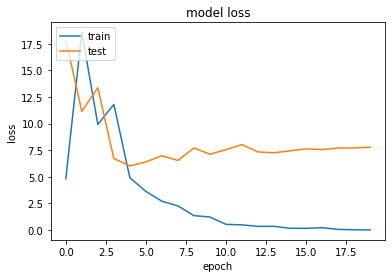

In [13]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## test the model


对要test的文本按之前做feature engineering一样的方式进行处理，让它可以fit进model

In [14]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        x[0, t, unique_word_index[word]] = 1
    return x

#prepare_input("It is not a lack".lower())

In [15]:
# function to return samples

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [16]:
# final function for prediction
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [char_indices[idx] + predict_completion(text[1:] + char_indices[idx]) for idx in next_indices]

## trial

In [17]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

quotes = ['how many people']

In [18]:
# for q in quotes:
#     seq = q[:40].lower()
#     print(seq)
#     print(predict_completions(seq, 5))
#     print()